In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [2]:
is_local = True

PROJECT_PATH =  pathlib.Path(".") / "MNIST-Digit 8k params"

## Data

### Load MNIST data

In [3]:
train_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  60000
Length of test data:  10000


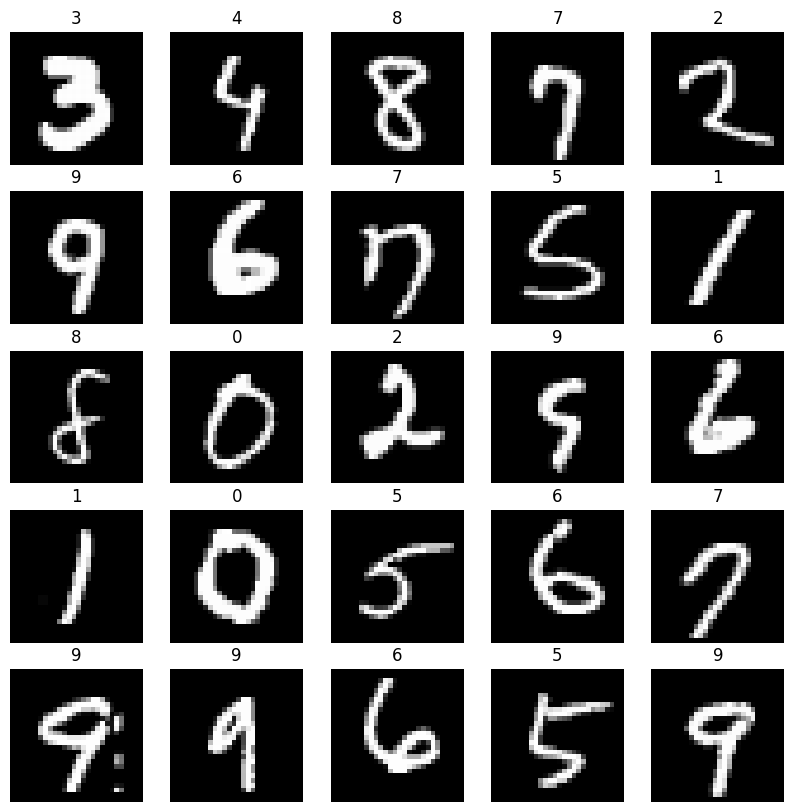

In [4]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=True)

## MODEL

### Network

In [29]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
        )
        self.out = nn.Linear(4*32, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output, x 
    
    def summary(self, verbose: int=1, **kwargs):
        """
        Prints the summary of the model.
        """
        summary(
            self,
            input_size=(1, 28, 28),
            batch_dim=0,
            col_names = ("input_size", "output_size", "num_params", "kernel_size"),
            verbose = verbose,
            **kwargs
            )

In [7]:
cnn = CNN()
cnn.summary()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNN                                      [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 8, 12, 12]            --                        --
│    └─Conv2d: 2-1                       [1, 1, 28, 28]            [1, 8, 26, 26]            80                        [3, 3]
│    └─ReLU: 2-2                         [1, 8, 26, 26]            [1, 8, 26, 26]            --                        --
│    └─Conv2d: 2-3                       [1, 8, 26, 26]            [1, 8, 24, 24]            584                       [3, 3]
│    └─ReLU: 2-4                         [1, 8, 24, 24]            [1, 8, 24, 24]            --                        --
│    └─MaxPool2d: 2-5                    [1, 8, 24, 24]            [1, 8, 12, 12]            --                        2
├─Seque

In [8]:
from torch import optim

loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(cnn.parameters(), lr = 0.0005)   

loss_func, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0005
     maximize: False
     weight_decay: 0
 ))

In [9]:
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import copy

num_epochs = 25

def train(
    num_epochs, 
    cnn, 
    train_loader, 
    test_loader, 
    loss_func, 
    optimizer
):
    
    cnn.train()
        
    total_step = len(train_loader)
    # loop = tqdm(train_loader, leave=True)
    
    for epoch in range(num_epochs):
        # for i, (images, labels) in enumerate(loop):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            loss.backward()    
            optimizer.step()                
            
            # loop.set_postfix(loss=loss.item())
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
               
        #  evaluate
        cnn_Copy = copy.deepcopy(cnn)
        accuracy = test(cnn_Copy, test_loader)
        print('Epoch [{}/{}], Accuracy: {:.2f}%'.format(epoch+1, num_epochs, accuracy))

        

def test(cnn, test_loader):
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            b_x = Variable(images)
            b_y = Variable(labels)
            output = cnn(b_x)[0]
            _, predicted = torch.max(output.data, 1)
            total += b_y.size(0)
            correct += (predicted == b_y).sum()
    accuracy = 100 * correct / total
    return accuracy

train(
    num_epochs,
    cnn,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer
)

Epoch [1/25], Step [200/938], Loss: 0.9080
Epoch [1/25], Step [400/938], Loss: 0.4068
Epoch [1/25], Step [600/938], Loss: 0.2414
Epoch [1/25], Step [800/938], Loss: 0.0888
Epoch [1/25], Accuracy: 95.90%
Epoch [2/25], Step [200/938], Loss: 0.0863
Epoch [2/25], Step [400/938], Loss: 0.2171
Epoch [2/25], Step [600/938], Loss: 0.1527
Epoch [2/25], Step [800/938], Loss: 0.1339
Epoch [2/25], Accuracy: 97.46%
Epoch [3/25], Step [200/938], Loss: 0.2151
Epoch [3/25], Step [400/938], Loss: 0.1787
Epoch [3/25], Step [600/938], Loss: 0.0838
Epoch [3/25], Step [800/938], Loss: 0.0188
Epoch [3/25], Accuracy: 97.88%
Epoch [4/25], Step [200/938], Loss: 0.0886
Epoch [4/25], Step [400/938], Loss: 0.0565
Epoch [4/25], Step [600/938], Loss: 0.1412
Epoch [4/25], Step [800/938], Loss: 0.0710
Epoch [4/25], Accuracy: 98.22%
Epoch [5/25], Step [200/938], Loss: 0.0374
Epoch [5/25], Step [400/938], Loss: 0.0227
Epoch [5/25], Step [600/938], Loss: 0.0726
Epoch [5/25], Step [800/938], Loss: 0.1101
Epoch [5/25], Ac

In [20]:
# save cnn
weights_path = PROJECT_PATH / 'weights/'
model_path = str(weights_path / 'cnn1.pt')
cnn_copy = copy.deepcopy(cnn)

torch.save(cnn_copy.state_dict(), model_path)

In [30]:
model = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

orig = []
pred = []

for i, (images, labels) in enumerate(test_dataloader):
    output = model(images)[0]
    _, predicted = torch.max(output.data, 1)
    
    orig += labels.tolist()
    pred += predicted.tolist()
    
orig = np.array(orig)
pred = np.array(pred)

accuracy = accuracy_score(orig, pred)
f1_score = f1_score(orig, pred, average='macro')

confusion_matrix = confusion_matrix(orig, pred)

accuracy, f1_score, confusion_matrix


(0.9915,
 0.9914759313391304,
 array([[ 973,    0,    1,    0,    0,    0,    3,    2,    1,    0],
        [   0, 1125,    1,    6,    0,    1,    1,    0,    1,    0],
        [   2,    0, 1027,    1,    0,    0,    0,    2,    0,    0],
        [   0,    0,    1, 1008,    0,    1,    0,    0,    0,    0],
        [   0,    0,    2,    0,  978,    0,    0,    0,    0,    2],
        [   1,    0,    0,    8,    0,  880,    2,    1,    0,    0],
        [   3,    4,    0,    0,    1,    0,  949,    0,    1,    0],
        [   0,    1,    7,    1,    0,    1,    0, 1017,    1,    0],
        [   0,    0,    1,    0,    2,    1,    1,    1,  967,    1],
        [   3,    0,    0,    3,    7,    2,    0,    3,    0,  991]]))

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

orig = []
pred = []

for i, (images, labels) in enumerate(train_dataloader):
    output = model(images)[0]
    _, predicted = torch.max(output.data, 1)
    
    orig += labels.tolist()
    pred += predicted.tolist()
    
orig = np.array(orig)
pred = np.array(pred)

accuracy = accuracy_score(orig, pred)
f1_score = f1_score(orig, pred, average='macro')

confusion_matrix = confusion_matrix(orig, pred)

accuracy, f1_score, confusion_matrix


(0.99435,
 0.9943171925641874,
 array([[5908,    1,    6,    0,    1,    0,    4,    0,    1,    2],
        [   0, 6702,   15,    5,    3,    0,    2,   13,    1,    1],
        [   0,    1, 5948,    0,    4,    0,    0,    5,    0,    0],
        [   0,    0,    5, 6122,    0,    1,    0,    0,    2,    1],
        [   1,    2,    1,    0, 5831,    0,    1,    1,    0,    5],
        [   0,    1,    3,   29,    3, 5358,   14,    4,    6,    3],
        [   3,    1,    2,    2,    3,    1, 5905,    0,    1,    0],
        [   0,    5,   13,    4,    7,    0,    0, 6234,    0,    2],
        [   2,    2,   11,   13,   10,    5,    7,    1, 5796,    4],
        [   4,    2,    2,    7,   57,    2,    0,   17,    1, 5857]]))